# Principle Curve Analysis on Riemannian Manifolds
Presented by: Steven Lin

## Main Reference
Hauberg, S. (2015). Principal curves on Riemannian manifolds. *IEEE transactions on pattern analysis and machine intelligence*, *38*(9), 1915-1921.

## Outline
- Introduction

- Background and Model

- Implementation

- Demonstration and Analysis

## Introduction (Motivation)
Euclidean PCA. 

In [5]:
import pga
import pga_curve
from matplotlib import pyplot as plt
import geomstats.visualization as visualization
import geomstats.backend as gs
from geomstats.geometry.hypersphere import Hypersphere, HypersphereMetric
from geomstats.learning.frechet_mean import FrechetMean
from importlib import reload 
import torch
import numpy as np


In [2]:
from geomstats.geometry.euclidean import Euclidean, EuclideanMetric
n = 2
space = Euclidean(n)
metric = space.metric
gs.random.seed(1)

n_samples = 100
# x is uniform from -3 to 3
samples_x = np.random.random(n_samples) * 6 - 3
# y is approximately parabolic
samples_y = 3/4 * (samples_x ** 2) + np.random.normal(loc = 10, scale = 1, size = n_samples)
# samples_y = np.random.normal(loc = 5, scale = 1/4, size = n_samples) - np.sin(samples_x)

samples = np.array([samples_x, samples_y]).T

estimator = FrechetMean(space.metric)
estimator.fit(torch.tensor(samples))
mean = estimator.estimate_


In [3]:
from geomstats.learning.pca import TangentPCA

tPCA = TangentPCA(metric = space.metric, n_components = 1)
tPCA = tPCA.fit(gs.array(samples))
path = space.metric.geodesic(
        initial_point=mean, initial_tangent_vec=tPCA.components_[0]
    )



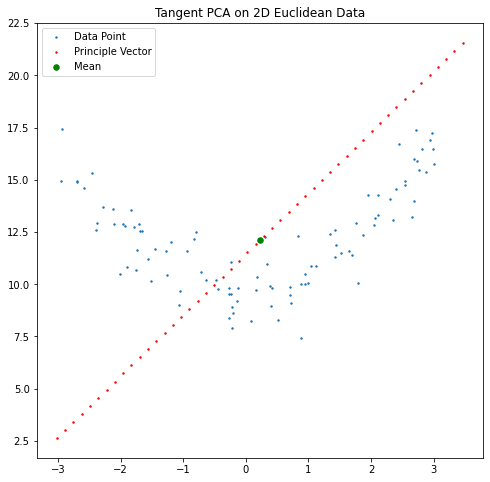

In [4]:
fig = plt.figure(figsize=(8, 8))
plt.cla()

plt.scatter(np.array(samples[:,0]), np.array(samples[:,1]), s = 2, label = 'Data Point')

t = np.linspace(-10, 10, 50)
vector_points = path(t)
plt.scatter(np.array(vector_points[:,0]), np.array(vector_points[:,1]), s = 2, c='red', label = 'Principle Vector')
plt.scatter(np.array(mean[0]), np.array(mean[1]), s = 30, c = 'g', label = 'Mean' )
plt.legend()
plt.title('Tangent PCA on 2D Euclidean Data')
plt.show()

## Problem with Euclidean PCA
1. It has to pass through the mean

2. It has to be straight


## Generalization to Riemannian Manifolds
Tangent Principle Geodesic Analysis (Fletcher *et al*) has similar restrictions: 
1. It has to pass through the **Frechet** Mean

2. It has to be a **geodesic**

In [5]:
from geomstats.geometry.poincare_half_space import PoincareHalfSpace, PoincareHalfSpaceMetric
import numpy as np
n = 2
space = PoincareHalfSpace(n)
metric = space.metric
gs.random.seed(1)

n_samples = 100
# x is uniform from -3 to 3
samples_x = np.random.random(n_samples) * 6 - 3
# y is approximately parabolic
# samples_y = 3/4 * (samples_x ** 2) + np.random.normal(loc = 10, scale = 1, size = n_samples)
# y is approximately sinusoidal
samples_y = np.random.normal(loc = 5, scale = 1/4, size = n_samples) - np.sin(samples_x)

samples = gs.array(np.array([samples_x, samples_y]).T)

estimator = FrechetMean(space.metric)
estimator.fit(samples)
mean = estimator.estimate_

In [6]:
proj, good_times, component = pga.pga(samples, mean, space = space, metric = metric, n_samples = n_samples, max_iter=150)
path = metric.geodesic(
    initial_point=mean, initial_tangent_vec=component)

path = metric.geodesic(
    initial_point=mean, initial_tangent_vec=[0.35, -0.25])

Projection: Convergence tol reached 
Final loss: tensor(15.2289)
pga_loss tensor(15.2289, grad_fn=<SumBackward0>)
PGA: Convergence tol reached
Final loss: tensor(15.2289, grad_fn=<SumBackward0>)
Projection: Convergence tol reached 
Final loss: tensor(15.2289)


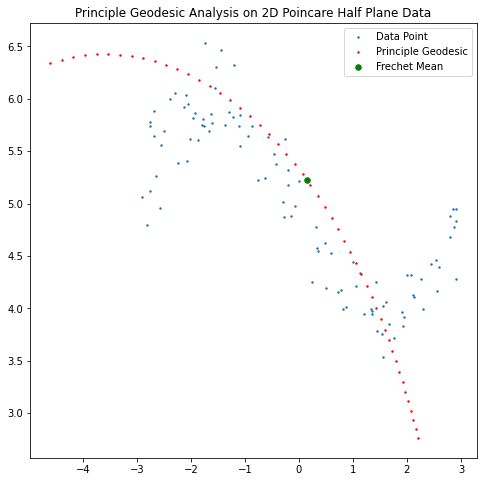

In [7]:
fig = plt.figure(figsize=(8, 8))
plt.cla()
plt.scatter(np.array(samples[:,0]), np.array(samples[:,1]), s = 2, label = 'Data Point')

t = np.linspace(-10, 10, 50)
geodesic_points = path(t)
plt.scatter(np.array(geodesic_points[:,0]), np.array(geodesic_points[:,1]), s = 2, c='red', label = 'Principle Geodesic')

plt.scatter(np.array(mean[0]), np.array(mean[1]), s = 30, c = 'g', label = 'Frechet Mean' )
plt.legend()

plt.title('Principle Geodesic Analysis on 2D Poincare Half Plane Data')
plt.show()

Still, it does not capture the trend of the data well.
- The Frechet mean might not be within the support of the other datapoints.
- There might be a trend in the data, but the trend might not follow a geodesic.

## Other Attempts
- Panaretos *et al*: Does not need to be a geodesic, but still has to pass through the Frechet mean

- Zhang & Fletcher *et al*: Probabalistic model that is based on Monte Carlo methods

- ...

## Background and Model: 
**Principle Curve on Riemannian Manifolds**
A Principle Curve: 
1. Does **not** have to pass through the Frechet mean

2. Does **not** have to be **a** geodesic

## Curve
- Discrete points 
$c_{1:T} = \{c(1), ..., c(T)\}$
joined by geodesics

- Self-consistent property: For any point $c(t)$ on the curve, $c(t)$ is the expectation(Frechet mean) of all data points that project onto it. 

<center><img src="images/self_consistency.png" width=650px alt=\"default\"/></center>
Image taken from the Hauberg. 

- The curve should be 'smooth' ideally


## The Algorithm
<center><img src="images/algorithm.png" width=650px alt=\"default\"/></center>
Presented by the Hauberg paper.

In words:

1. Initialize the curve with discrete points from the **principle geodesic**

2. For each data point $x_n$, find the projected (closest in geodesic distance) point on the curve $c(\hat{t}_n)$ and store the index $\hat{t}_n$

3. Quartic smoothing kernel $k(\Delta) = (1-\Delta^2)^2 \cdot \delta_{|\Delta|\leq 1}$. (Smooth curve)

4. Update each point on the curve to be a **weighted** Frechet mean. (Self - Consistency)

5. Repeat 2-4 until convergence

## Result Illustration

In [8]:
reload(pga_curve)
pga_curve_estimate = pga_curve.PGA_Curve(metric = metric)
t = np.linspace(-8, 8, 50)
geodesic_points = path(t)
curve = pga_curve_estimate.fit(points = samples, curve = path(t), num_iterations = 5, sigma = 1/4)

[[-2.1778786 -2.1749172 -2.1706605 ...  2.4251409  2.4259348  2.426765 ]
 [ 5.71054    5.7117834  5.713519  ...  4.3866687  4.3872404  4.3878417]
 [-2.1778183 -2.1748292 -2.1705623 ...  2.4251556  2.425952   2.4267795]
 ...
 [ 5.711757   5.713494   5.7155128 ...  4.3872275  4.387829   4.3883495]
 [-2.174917  -2.1706638 -2.1655943 ...  2.4259324  2.4267626  2.4274874]
 [ 5.7117834  5.7135267  5.7155566 ...  4.387236   4.3878374  4.388363 ]]


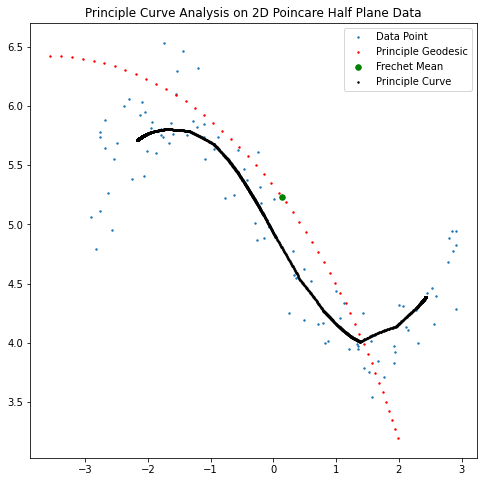

In [9]:
fig = plt.figure(figsize=(8, 8))
plt.cla()
plt.scatter(np.array(samples[:,0]), np.array(samples[:,1]), s = 2, label = 'Data Point')
plt.scatter(np.array(geodesic_points[:,0]), np.array(geodesic_points[:,1]), s = 2, c='red', label = 'Principle Geodesic')

plt.scatter(np.array(mean[0]), np.array(mean[1]), s = 30, c = 'g', label = 'Frechet Mean' )

principle_curve = []
for j in range(len(curve) - 1):
    geodesic = metric.geodesic(initial_point= curve[j], end_point= curve[j+1])
    principle_curve.append(np.array(geodesic(np.linspace(0,1,50))))
principle_curve = np.stack(principle_curve, axis = 2)
print(np.concatenate(principle_curve))

plt.scatter(np.array(principle_curve[:,0]), np.array(principle_curve[:,1]), s = 2, c='black', label = 'Principle Curve')

plt.legend()
plt.title('Principle Curve Analysis on 2D Poincare Half Plane Data')
plt.show()

## Effect of Initialization
- Paper: Initialize with points along the principle geodesic
- What if we initialize with something bad? 

In [10]:
path = metric.geodesic(
    initial_point=mean, initial_tangent_vec=[0.35, 0.25])
reload(pga_curve)
pga_curve_estimate = pga_curve.PGA_Curve(metric = metric)
t = np.linspace(-8, 8, 50)
geodesic_points = path(t)
curve = pga_curve_estimate.fit(points = samples, curve = path(t), num_iterations = 5, sigma = 1/2)

[[-1.7089587 -1.7081938 -1.7073784 ...  1.7771724  1.7777176  1.7782022]
 [ 5.70953    5.709372   5.7092037 ...  4.2627463  4.262628   4.26252  ]
 [-1.7089483 -1.7081847 -1.7073615 ...  1.7771817  1.7777237  1.7782087]
 ...
 [ 5.709373   5.7092094  5.7090197 ...  4.262626   4.2625237  4.262433 ]
 [-1.7081912 -1.7073787 -1.7064496 ...  1.7777154  1.778202   1.7786379]
 [ 5.7093663  5.7092013  5.709021  ...  4.262626   4.26252    4.2624297]]


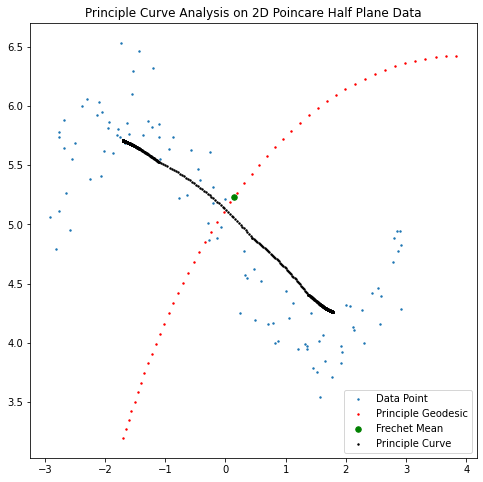

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.cla()
plt.scatter(np.array(samples[:,0]), np.array(samples[:,1]), s = 2, label = 'Data Point')
plt.scatter(np.array(geodesic_points[:,0]), np.array(geodesic_points[:,1]), s = 2, c='red', label = 'Principle Geodesic')

plt.scatter(np.array(mean[0]), np.array(mean[1]), s = 30, c = 'g', label = 'Frechet Mean' )

principle_curve = []
for j in range(len(curve) - 1):
    geodesic = metric.geodesic(initial_point= curve[j], end_point= curve[j+1])
    principle_curve.append(np.array(geodesic(np.linspace(0,1,50))))
principle_curve = np.stack(principle_curve, axis = 2)
print(np.concatenate(principle_curve))

plt.scatter(np.array(principle_curve[:,0]), np.array(principle_curve[:,1]), s = 2, c='black', label = 'Principle Curve')

plt.legend()
plt.title('Principle Curve Analysis on 2D Poincare Half Plane Data')
plt.show()

If we initialize the curve with something that does not characterize the trend well. We are still able to find a principle curve that works, but the effect is worse than if we initialize it with a good estimate. 

## Effect of Smoothing Kernel Spread
Recall:
<center><img src="images/algorithm.png" width=650px alt=\"default\"/></center>
Presented by the Hauberg paper.

Smoothing kernel $k(\Delta) = (1-\Delta^2)^2 \cdot \delta_{|\Delta|\leq 1}$. (Smooth curve)

- Larger $\sigma$: Points further away are 'averaged together', making the curve 'too smooth'.

- Smaller $\sigma$: We are not really smoothing the curve, make the curve not smooth enough.

In [12]:
# Larger sigma
reload(pga_curve)
path = metric.geodesic(
    initial_point=mean, initial_tangent_vec=[0.35, -0.25])
pga_curve_estimate = pga_curve.PGA_Curve(metric = metric)
t = np.linspace(-8, 8, 50)
geodesic_points = path(t)
curve = pga_curve_estimate.fit(points = samples, curve = path(t), num_iterations = 5, sigma = 1/2)

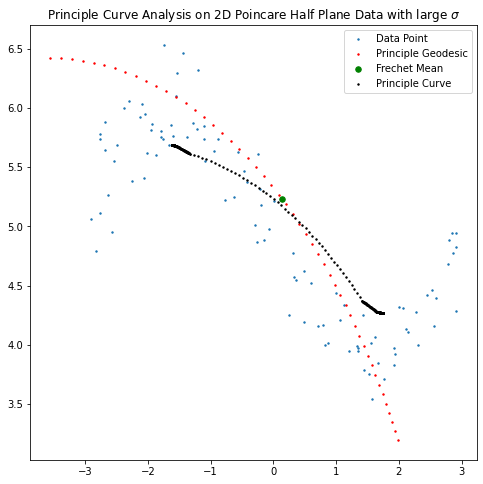

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.cla()
plt.scatter(np.array(samples[:,0]), np.array(samples[:,1]), s = 2, label = 'Data Point')
plt.scatter(np.array(geodesic_points[:,0]), np.array(geodesic_points[:,1]), s = 2, c='red', label = 'Principle Geodesic')

plt.scatter(np.array(mean[0]), np.array(mean[1]), s = 30, c = 'g', label = 'Frechet Mean' )

principle_curve = []
for j in range(len(curve) - 1):
    geodesic = metric.geodesic(initial_point= curve[j], end_point= curve[j+1])
    principle_curve.append(np.array(geodesic(np.linspace(0,1,50))))
principle_curve = np.stack(principle_curve, axis = 2)
plt.scatter(np.array(principle_curve[:,0]), np.array(principle_curve[:,1]), s = 2, c='black', label = 'Principle Curve')

plt.legend()
plt.title(r'Principle Curve Analysis on 2D Poincare Half Plane Data with large $\sigma$')
plt.show()

In [19]:
# Smaller sigma
reload(pga_curve)
path = metric.geodesic(
    initial_point=mean, initial_tangent_vec=[0.35, -0.25])
pga_curve_estimate = pga_curve.PGA_Curve(metric = metric)
t = np.linspace(-8, 8, 50)
geodesic_points = path(t)
curve = pga_curve_estimate.fit(points = samples, curve = path(t), num_iterations = 5, sigma = 1/6)

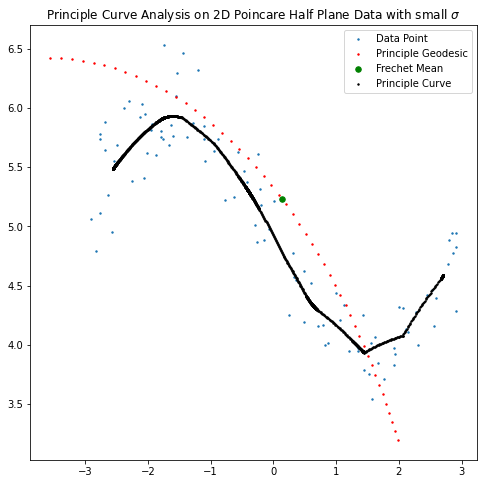

In [21]:
fig = plt.figure(figsize=(8, 8))
plt.cla()
plt.scatter(np.array(samples[:,0]), np.array(samples[:,1]), s = 2, label = 'Data Point')
plt.scatter(np.array(geodesic_points[:,0]), np.array(geodesic_points[:,1]), s = 2, c='red', label = 'Principle Geodesic')

plt.scatter(np.array(mean[0]), np.array(mean[1]), s = 30, c = 'g', label = 'Frechet Mean' )

principle_curve = []
for j in range(len(curve) - 1):
    geodesic = metric.geodesic(initial_point= curve[j], end_point= curve[j+1])
    principle_curve.append(np.array(geodesic(np.linspace(0,1,50))))
principle_curve = np.stack(principle_curve, axis = 2)

plt.scatter(np.array(principle_curve[:,0]), np.array(principle_curve[:,1]), s = 2, c='black', label = 'Principle Curve')

plt.legend()
plt.title(r'Principle Curve Analysis on 2D Poincare Half Plane Data with small $\sigma$')
plt.show()

## For the Shape Space
We can also perform principle shape analysis on the shape space, e.g. the shape of all 3D triangles for easier visualization. 

Synthetic data points are used.


In [1]:
# Use Principle Curves on the Landmarks Data
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import PreShapeSpace, PreShapeMetric, KendallShapeMetric
import numpy as np

# Keep the firsts three landmarks
k_landmarks = 3
m_ambient = 3
points = []

preshapeMetric = PreShapeMetric(k_landmarks=k_landmarks, m_ambient=m_ambient)
preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)

base_point = ([[-0.43331545, -0.09098209,  0.23584489],
       [-0.302747  , -0.06304494,  0.05438993],
       [ 0.73606244,  0.15402703, -0.29023482]])
vec1 = np.array([[-0.5,-0.5,-0.5], [1., 1., 1.], [-1., -1., -1.]])
vec2 = np.array([[1,1,1], [-0.5, -0.5, -0.5], [1., 1., 1.]])
point1 = preshapeMetric.exp(tangent_vec=0.05 * vec1, base_point=base_point)
point2 = preshapeMetric.exp(tangent_vec=0.1 * vec1, base_point=base_point)
point3 = preshapeMetric.exp(tangent_vec=0.15 * vec1, base_point=base_point)
point4 = preshapeMetric.exp(tangent_vec=0.1 * vec2, base_point=base_point)
point5 = preshapeMetric.exp(tangent_vec=0.2 * vec2, base_point=base_point)

points = [base_point,point1,point2,point3, point4, point5]




INFO: Using numpy backend


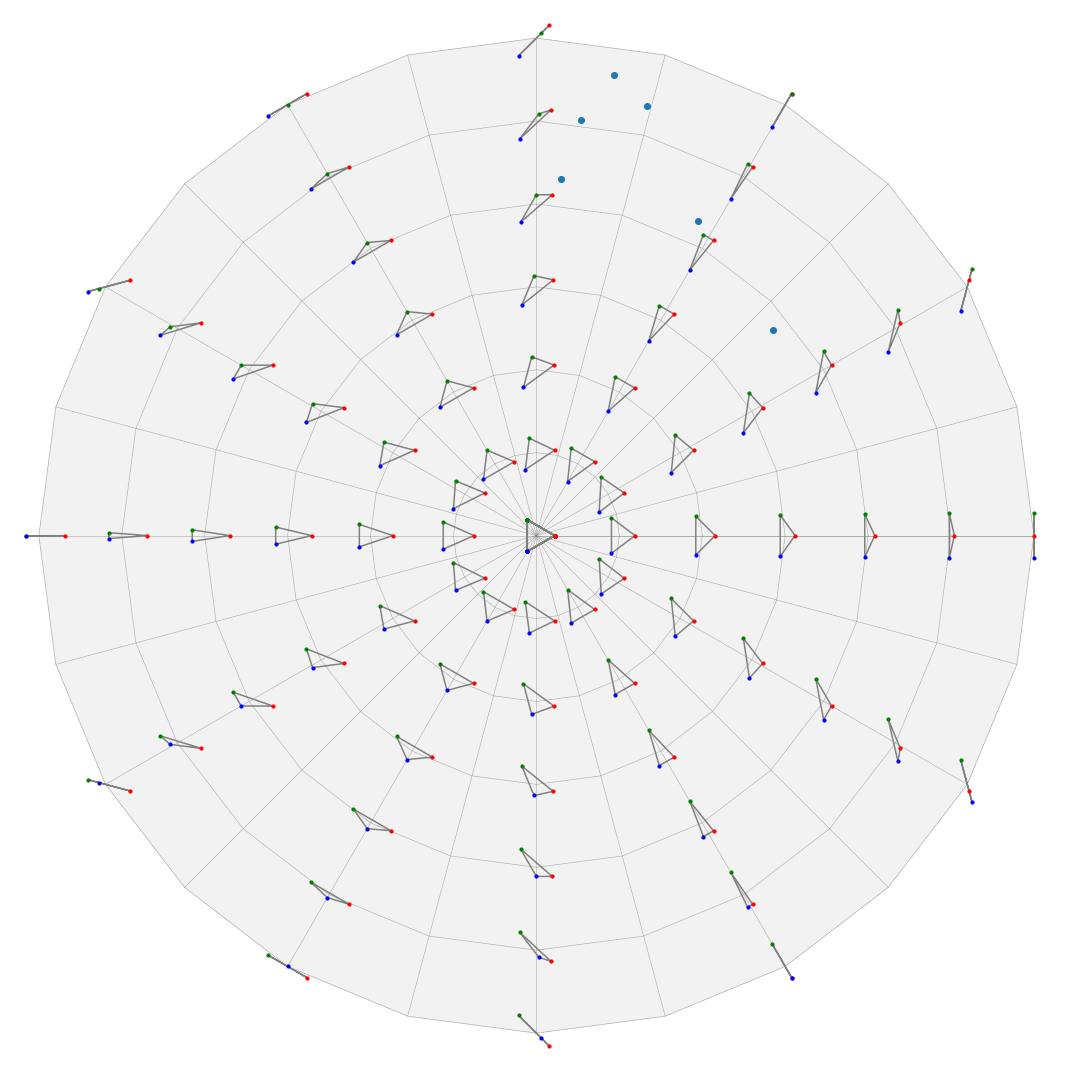

In [2]:
# The original data points
from geomstats.visualization import KendallDisk
from matplotlib import pyplot as plt
D = KendallDisk(points=np.array(points))
fig = plt.figure(figsize=(15, 15))
D.draw()
D.draw_points()

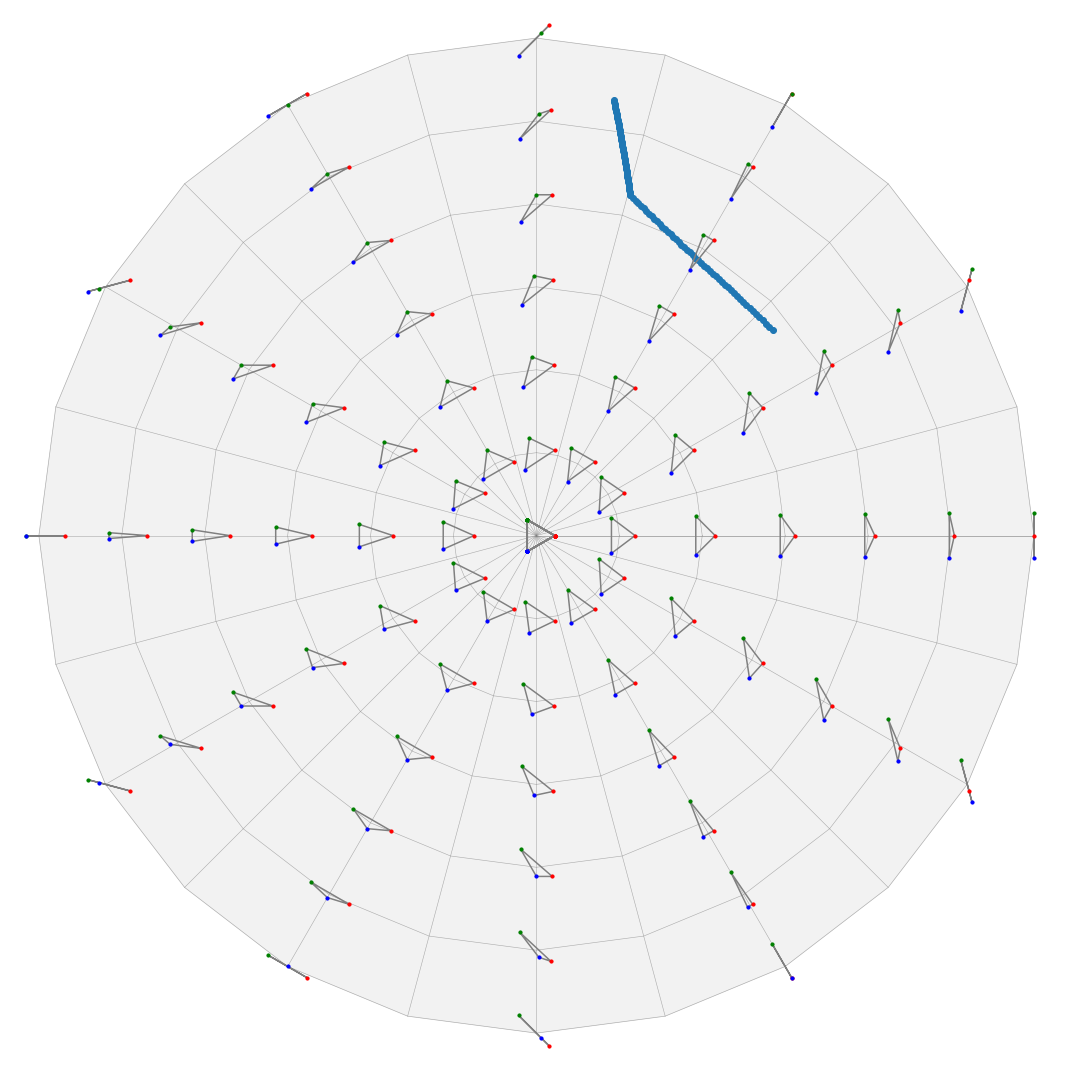

In [6]:
# The principle curve
kendallMetric = KendallShapeMetric(3,3)
reload(pga_curve)
pga_curve_estimate = pga_curve.PGA_Curve(kendallMetric)
curve = gs.array([points[0], points[3], points[5]])

principle_curve = pga_curve_estimate.fit(points = points, curve = curve, num_iterations = 5, sigma = 1/6)

# Connect the points with geodesics
principle_curve_points = []
for j in range(len(curve) - 1):
    geodesic = kendallMetric.geodesic(initial_point= principle_curve[j], end_point= principle_curve[j+1])
    principle_curve_points.append(np.array(geodesic(np.linspace(0,1,50))))
principle_curve_points = np.concatenate(principle_curve_points, axis = 0)
D = KendallDisk(points=principle_curve_points)
fig = plt.figure(figsize=(15, 15))
D.draw()
D.draw_points()




From the example with the shape of 3D triangles, it can be seen that the curve does not characterize the trend very well. This is because there is not enough data points for it to find a good trend. In addition, because the self-consistency has to be satisfied, the discrete points along the principle curve settles down around mid-way between a few pair of points, which is not really what we are looking for. 

## Final Remarks

- Pro: 
    1. Relatively straightforward algorithm

    2. We can characterize the trend in the data better, if a trend exists at all.

    3. We can fit a curve to 'zig-zag' shaped data

- Con: 
    1. We are not really simplifying the data a lot - we have to keep track of a lot of points and the geodesics between them.

    2. Trend might be well characterized with a principle geodesic already with less overhead

    3. We need a reasonable initial guess and a good smoothing kernel to be able to get a good curve.